In [1]:
import os
import subprocess
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'font.size': 11})

In [2]:
org_model_ws = os.path.join('..', '2022_03_18_calib') # WS of calibrated model. For inquiries contact the corresponding author.
ml_ws = os.path.join('..', 'temp_ml_ies') # New WS

In [3]:
if os.path.exists(ml_ws):
    shutil.rmtree(ml_ws)

os.mkdir(ml_ws)

In [4]:
shutil.copytree(org_model_ws, ml_ws, dirs_exist_ok=True)

'..\\temp_ml_ies'

In [6]:
pest_ws = os.path.join(ml_ws, 'pest')

In [7]:
# Clean up directory
#for file in os.listdir(pest_ws):
#    if 'calib1-wt-cov' in file:
#        os.remove(os.path.join(pest_ws, file))

In [8]:
# objective function reduction
ofr = pd.read_csv(os.path.join(pest_ws, 'calib1-wt-cov-linux.ofr'), skiprows=3, delim_whitespace=True)

In [9]:
ofr

,iteration,measurement,regularisation,heads,stage1,gage1,gage2,dh_hedstg,>@dts,>@of,heads_d,stage1_d,gage1_d,gage2_d,pfluxb,pofb,pfluxr,pofr
0,0,8999.95,3.085332e-11,999.9660,999.987,999.999,999.997,999.9980,0.000000,0.000000e+00,1000.000,1000.000,999.999,1000.000,0.0,0.0,0.0,0.0
1,1,3289.86,2.794500e+03,337.9160,363.994,311.202,252.856,216.8440,0.000000,0.000000e+00,666.876,773.725,238.237,128.207,0.0,0.0,0.0,0.0
2,2,2356.38,2.707300e+04,270.4810,265.250,232.707,151.197,127.0350,0.000000,0.000000e+00,540.483,485.057,177.396,106.773,0.0,0.0,0.0,0.0
3,3,2172.08,5.038560e+04,217.0090,209.842,239.471,152.862,103.5840,0.000000,1.292470e-26,515.794,444.314,186.256,102.950,0.0,0.0,0.0,0.0
4,4,2076.80,7.653930e+04,104.4580,164.771,252.557,154.742,66.9273,0.030801,0.000000e+00,593.259,434.341,194.961,110.749,0.0,0.0,0.0,0.0
5,5,1889.47,8.471520e+04,82.3948,151.731,244.106,148.464,57.3117,0.000000,0.000000e+00,479.473,430.702,189.262,106.031,0.0,0.0,0.0,0.0
6,6,1866.42,9.955970e+04,80.5547,149.971,251.497,144.541,57.9934,0.000000,0.000000e+00,467.624,416.621,195.026,102.587,0.0,0.0,0.0,0.0
7,7,1860.00,1.077050e+05,78.8022,143.260,252.348,146.962,57.3447,0.000000,0.000000e+00,466.578,414.875,196.407,103.423,0.0,0.0,0.0,0.0
8,8,1860.00,1.077050e+05,78.8022,143.260,252.348,146.962,57.3447,0.000000,0.000000e+00,466.578,414.875,196.407,103.423,0.0,0.0,0.0,0.0


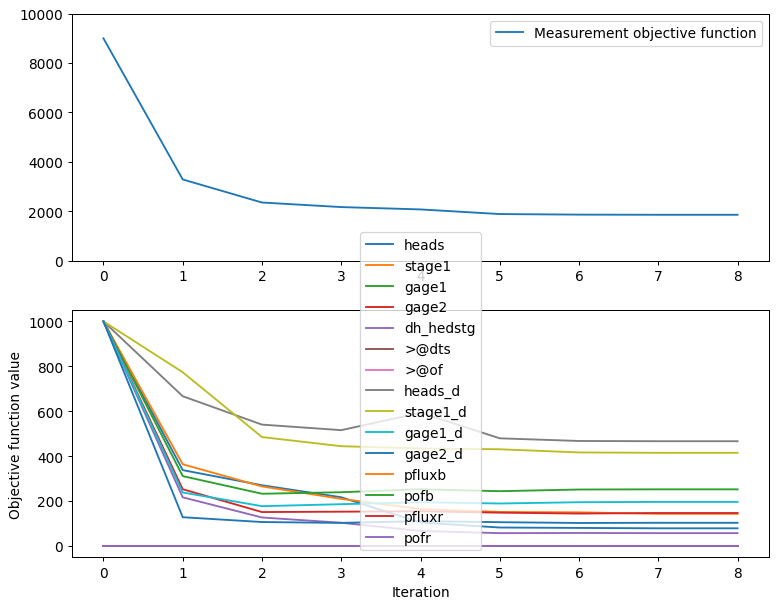

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=90)

axs[0].plot(ofr['measurement'], label='Measurement objective function')
axs[0].set_ylim([0, 10000])
axs[0].legend()

for col in ofr.columns:
    if col in ['measurement', 'iteration', 'regularisation']:
        continue
    else:
        axs[1].plot(ofr[col], label=col)
        axs[1].legend(fontsize=8)
        
    
plt.xlabel('Iteration')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### Run parrep

In [11]:
p = subprocess.run([
    'parrep',
    'calib1-wt-cov-linux.par.5',
    'calib1-wt-cov-linux.pst',
    'calib-parrep.pst',
    '0'
], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)


PARREP Version 17.3. Watermark Numerical Computing.

Reading parameter value file calib1-wt-cov-linux.par.5 ----->
Data for 1709 parameters read from file calib1-wt-cov-linux.par.5.

Reading file calib1-wt-cov-linux.pst and writing file calib-parrep.pst ----->
File calib-parrep.pst written ok.



In [12]:
reifname = 'calib1-wt-cov-linux.rei.5'

with open(os.path.join(pest_ws, reifname), 'r') as file:
    reifile = file.readlines()

reifile = [i.replace('Cov. Mat.', 'covmat') for i in reifile]

with open(os.path.join(pest_ws, 'calib-parrep.rei'), 'w') as file:
    for line in reifile:
        file.write(line)

In [13]:
rei_df = pd.read_csv(os.path.join(pest_ws, 'calib-parrep.rei'), skiprows=8, delim_whitespace=True)

# remove regularization groups and prediction groups
rei_df = rei_df[~rei_df.Group.str.contains('regul')]
rei_df = rei_df[~rei_df.Group.str.contains('pof')]
rei_df = rei_df[~rei_df.Group.str.contains('pflux')]

rei_df

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Name,Group,Measured,Modelled,Residual,Weight
0,b10-1_1,heads,133.695,133.2147,0.480348,0.897773
1,b10-1_2,heads,133.620,133.1241,0.495926,0.897773
2,b10-1_3,heads,133.480,133.1400,0.339990,0.897773
3,b10-1_4,heads,133.425,133.1398,0.285171,0.897773
4,b14-1_1,heads,140.200,139.8718,0.328216,0.897773
...,...,...,...,...,...,...
54265,gage-2_d417,gage2_d,19029.440,26836.5700,-7807.130000,8.528e-05
54266,gage-2_d418,gage2_d,20350.640,25605.8300,-5255.187000,8.528e-05
54267,gage-2_d419,gage2_d,28432.640,24375.0800,4057.556000,8.528e-05
54268,gage-2_d420,gage2_d,29894.240,23144.3400,6749.898000,8.528e-05


### Generate observation realizations

In [17]:
p = subprocess.run(
    ['subreg1', 'calib-parrep.pst', 'ies-postcalib.pst'],
    cwd=pest_ws,
    stdout=subprocess.PIPE,
    text=True
)
for row in p.stdout.split('\n'):
    print(row)


 SUBREG1 version 17.3. Watermark Numerical Computing.

 - file calib-parrep.pst read ok.
 - file ies-postcalib.pst written ok.



In [18]:
# Clean up directory
for file in os.listdir(pest_ws):
    if 'calib-parrep' in file:
        os.remove(os.path.join(pest_ws, file))

In [19]:
# Clean up directory
for file in os.listdir(pest_ws):
    if 'calib1-wt-cov-linux' in file:
        os.remove(os.path.join(pest_ws, file))

### Create parameter uncertainty file

In [20]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [27]:
write_script(os.path.join(pest_ws, 'param.unc'), [
f'''
### HYDRAULIC CONDUCTIVITY ###

# Kh
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_cond.mat"
first_parameter khpp001
last_parameter khpp680
variance_multiplier 0.25
END COVARIANCE_MATRIX


### STORAGE ###

# Sy
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sy_rchmul.mat"
first_parameter sypp001
last_parameter sypp221
variance_multiplier 0.025
END COVARIANCE_MATRIX

### RCH Multiplier ###

# Rchmul
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sy_rchmul.mat"
first_parameter rchmulpp001
last_parameter rchmulpp221
variance_multiplier 0.25
END COVARIANCE_MATRIX

### GENERAL HEAD BOUNDARIES ###

# GHB Red
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_red.mat"
first_parameter ghbcredpp01
last_parameter ghbcredpp13
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Yellow
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_yellow.mat"
first_parameter ghbcyelpp01
last_parameter ghbcyelpp18
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Green
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_green.mat"
first_parameter ghbcgrepp01
last_parameter ghbcgrepp15
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Blue
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_blue.mat"
first_parameter ghbcblupp01
last_parameter ghbcblupp19
variance_multiplier 0.25
END COVARIANCE_MATRIX

### STREAMFLOW ROUTING ###

# SFR man
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrppman001
last_parameter sfrppman053
variance_multiplier 0.02
END COVARIANCE_MATRIX

# SFR rbth
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprbth001
last_parameter sfrpprbth053
variance_multiplier 0.2
END COVARIANCE_MATRIX

# SFR rgrd
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprgrd001
last_parameter sfrpprgrd053
variance_multiplier 0.5
END COVARIANCE_MATRIX

# SFR rwid
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprwid001
last_parameter sfrpprwid053
variance_multiplier 0.1
END COVARIANCE_MATRIX

# SFR rhk
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprhk001
last_parameter sfrpprhk053
variance_multiplier 0.25
END COVARIANCE_MATRIX

# SFR reach 1 inflow
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr_inf1.mat"
first_parameter sfrinflow000
last_parameter sfrinflow213
variance_multiplier 0.15
END COVARIANCE_MATRIX

### NON COVARIANCE MATRIX PARAMETERS ###

# SFR rtp
START STANDARD_DEVIATION
sfrrtpexcoef 0.5
sfrrtpoffset 0.5
sfrrtpsigma 0.5
END STANDARD_DEVIATION

# SFR reach evaporation and rainfall multipliers
START STANDARD_DEVIATION
sfr_ev_mul 0.5
sfr_rf_mul 0.5
END STANDARD_DEVIATION

# GHB yellow and blue multipliers
START STANDARD_DEVIATION
ghbyellomult 1.0
ghbbluemult 0.75
END STANDARD_DEVIATION

# Lumprem crop factor
START STANDARD_DEVIATION
crfac_lu1 0.2
crfac_red 0.2
crfac_yel 0.2
crfac_gre 0.2
crfac_blu 0.2
END STANDARD_DEVIATION

# Lumprem gamma
START STANDARD_DEVIATION
gamma_lu1 0.1
gamma_red 0.1
gamma_yel 0.1
gamma_gre 0.1
gamma_blu 0.1
END STANDARD_DEVIATION

# Lumprem ks
START STANDARD_DEVIATION
ks_lu1 0.1
ks_red 0.1
ks_yel 0.1
ks_gre 0.1
ks_blu 0.1
END STANDARD_DEVIATION

# Lumprem m
START STANDARD_DEVIATION
m_lu1 0.25
m_red 0.25
m_yel 0.25
m_gre 0.25
m_blu 0.25
END STANDARD_DEVIATION

# Lumprem factor 1 (for GHB models)
START STANDARD_DEVIATION
f1_red 0.15
f1_yel 0.15
f1_gre 0.15
f1_blu 0.15
END STANDARD_DEVIATION

# Lumprem factor 2 (for GHB models)
START STANDARD_DEVIATION
f2_red 0.15
f2_yel 0.15
f2_gre 0.15
f2_blu 0.15
END STANDARD_DEVIATION

# Lumprem power (for GHB models)
START STANDARD_DEVIATION
p_red 0.2
p_yel 0.2
p_gre 0.2
p_blu 0.2
END STANDARD_DEVIATION

# Lumprem offset (for GHB models)
START STANDARD_DEVIATION
of_red 0.1
of_yel 0.1
of_gre 0.1
of_blu 0.1
END STANDARD_DEVIATION
'''
])

### Set weights according to standard deviation of measurement noise 

In [28]:
with open(os.path.join(pest_ws, 'ies-postcalib.pst'), 'r') as f:
    pstfile = f.readlines()

obs_strt = pstfile.index('* observation data\n') + 1
obs_stop = pstfile.index('* model command line\n')

In [29]:
df = pd.DataFrame(
    [i.split() for i in pstfile[obs_strt:obs_stop]],
    columns=['OBSNME', 'OBSVAL', 'WEIGHT', 'OBGNME']
)
df

,OBSNME,OBSVAL,WEIGHT,OBGNME
0,b10-1_1,133.6950,0.897773,heads
1,b10-1_2,133.6200,0.897773,heads
2,b10-1_3,133.4800,0.897773,heads
3,b10-1_4,133.4250,0.897773,heads
4,b14-1_1,140.2000,0.897773,heads
...,...,...,...,...
172054,of-262_209,-17823.07,0.00000,pofr
172055,of-262_210,-17984.90,0.00000,pofr
172056,of-262_211,-18149.07,0.00000,pofr
172057,of-262_212,-17895.09,0.00000,pofr


In [30]:
# Back calculate measurement noise from calibrated model
rei_df['new_weight'] = 1 / (abs(rei_df.Residual) / 2)
rei_df

,Name,Group,Measured,Modelled,Residual,Weight,new_weight
0,b10-1_1,heads,133.695,133.2147,0.480348,0.897773,4.163648
1,b10-1_2,heads,133.620,133.1241,0.495926,0.897773,4.032860
2,b10-1_3,heads,133.480,133.1400,0.339990,0.897773,5.882526
3,b10-1_4,heads,133.425,133.1398,0.285171,0.897773,7.013336
4,b14-1_1,heads,140.200,139.8718,0.328216,0.897773,6.093548
...,...,...,...,...,...,...,...
54265,gage-2_d417,gage2_d,19029.440,26836.5700,-7807.130000,8.528e-05,0.000256
54266,gage-2_d418,gage2_d,20350.640,25605.8300,-5255.187000,8.528e-05,0.000381
54267,gage-2_d419,gage2_d,28432.640,24375.0800,4057.556000,8.528e-05,0.000493
54268,gage-2_d420,gage2_d,29894.240,23144.3400,6749.898000,8.528e-05,0.000296


Add *minimum* stdev as measurement noise:

In [40]:
for group in rei_df.Group.unique():
    if group in ['heads', 'stage1']:
        rei_df.loc[(rei_df.Group == group) & (rei_df.new_weight > 10), 'new_weight'] = 10
    elif group in ['heads_d', 'stage1_d', 'dh_hedstg']:
        rei_df.loc[(rei_df.Group == group) & (rei_df.new_weight > 100), 'new_weight'] = 100

Set weights to df according to back calculated standard deviations in calibration reifile (all groups except stages):

In [46]:
df.loc[df.OBGNME == 'heads', 'WEIGHT'] = rei_df.loc[rei_df.Group == 'heads', 'new_weight']
df.loc[df.OBGNME == 'heads_d', 'WEIGHT'] = rei_df.loc[rei_df.Group == 'heads_d', 'new_weight']
df.loc[df.OBGNME == 'stage1', 'WEIGHT'] = rei_df.loc[rei_df.Group == 'stage1', 'new_weight']
df.loc[df.OBGNME == 'stage1_d', 'WEIGHT'] = rei_df.loc[rei_df.Group == 'stage1_d', 'new_weight']
df.loc[df.OBGNME == 'dh_hedstg', 'WEIGHT'] = rei_df.loc[rei_df.Group == 'dh_hedstg', 'new_weight']

In [47]:
# Set gage1 measurement error at 20% of measured value (for all non-zero obs):
gage1_weights = [round(1/(float(i) * .2) ,6) for i in df.loc[(df['OBGNME'] == 'gage1') & (df['WEIGHT'] != '0.00000')].OBSVAL.values]
gage1_d_weights = [abs(round(1/(float(i) * .02) ,6)) for i in df.loc[(df['OBGNME'] == 'gage1_d') & (df['WEIGHT'] != '0.00000')].OBSVAL.values]

In [48]:
#Set gage2 measurement error at 10% of measured value (for all non-zero obs):
gage2_weights = [round(1/(float(i) * .1), 6) for i in df.loc[df['OBGNME'] == 'gage2'].OBSVAL.values]
gage2_d_weights = [abs(round(1/(float(i) * .01), 6)) for i in df.loc[df['OBGNME'] == 'gage2_d'].OBSVAL.values]

In [49]:
#Set weights for gage1, gage2, dts and of

In [50]:
df.loc[(df['OBGNME'] == 'gage1') & (df['WEIGHT'] != '0.00000'), 'WEIGHT'] = gage1_weights
df.loc[(df['OBGNME'] == 'gage1_d') & (df['WEIGHT'] != '0.00000'), 'WEIGHT'] = gage1_d_weights
df.loc[df['OBGNME'] == 'gage2', 'WEIGHT'] = gage2_weights
df.loc[df['OBGNME'] == 'gage2_d', 'WEIGHT'] = gage2_d_weights
df.loc[df['OBGNME'] == '>@dts', 'WEIGHT'] = 0 # No measurement noise
df.loc[df['OBGNME'] == '>@of', 'WEIGHT'] = 0 # No measurement noise

In [51]:
# Change obsname to conform to Pest++ nomenclature
df.loc[df.OBGNME == '>@dts', 'OBGNME'] = 'g_dts'
df.loc[df.OBGNME == '>@of', 'OBGNME'] = 'g_of'

In [52]:
#Just some calculations

In [53]:
# pestpp-ies takes weight == inverse of stdev of measurement uncertainty
# ex1. stdev of measurement uncertainty is 10 cm
print(f'ex1: {1 / 0.1}')

# ex2. b10-1_1 measured (133.695) vs modelled (133.2147) - residual (0.48) -  calibrated with pest_hp
print(f'ex2: {1 / np.std([133.695, 133.2147])}')
print(f'ex2 using residual: {1 / (0.480348/2)}') # Works too, i.e. stdev of measurement uncertainty == 0.48 / 2 == 24 cm

# ex3. ni1802-1_5 measured (134.0683) vs modelled (134.1154) - residual (0.047) - calibrated with pest_hp
print(f'ex3: {1 / np.std([134.0683, 134.1154])}')

ex1: 10.0
ex2: 4.164064126587552
ex2 using residual: 4.1636480218508245
ex3: 42.46284501061538


In [54]:
# Set weights to the inverse of the standard deviation of measurement noise
#df.loc[df['OBGNME'] == 'heads', 'WEIGHT'] = 1 / 0.1 # stdev of head measurement noise (10 cm)
#df.loc[df['OBGNME'] == 'heads_d', 'WEIGHT'] = 1 / 0.01 # stdev of head differences measurement noise (1cm)
#df.loc[df['OBGNME'] == 'stage1', 'WEIGHT'] = 1 / 0.1 # stdev of stage measurement noise (10cm)
#df.loc[df['OBGNME'] == 'stage1_d', 'WEIGHT'] = 1 / 0.01 # stdev of stage differences measurement noise (1.5cm)
#df.loc[df['OBGNME'] == 'dh_hedstg', 'WEIGHT'] = 1 / 0.01 # stdev of head/stage differences measurement noise (1.5cm)
#df.loc[(df['OBGNME'] == 'gage1') & (df['WEIGHT'] != '0.00000'), 'WEIGHT'] = gage1_weights
#df.loc[(df['OBGNME'] == 'gage1_d') & (df['WEIGHT'] != '0.00000'), 'WEIGHT'] = gage1_d_weights
#df.loc[df['OBGNME'] == 'gage2', 'WEIGHT'] = gage2_weights
#df.loc[df['OBGNME'] == 'gage2_d', 'WEIGHT'] = gage2_d_weights
#df.loc[df['OBGNME'] == 'g_dts', 'WEIGHT'] = 0 # No measurement noise
#df.loc[df['OBGNME'] == 'g_of', 'WEIGHT'] = 0 # No measurement noise

In [55]:
# Zero-weight unreliable field measurement
df.loc[df.OBSNME == 'gage-1_1430', 'WEIGHT'] = '0.00000'
df.loc[df.OBSNME == 'gage-1_d1430', 'WEIGHT'] = '0.00000'

In [56]:
df['OBGNME'] = df['OBGNME'] + '\n'

In [57]:
obsdata = ['* observation data\n']
for i in df.values.tolist():
    obsdata.append(' '.join(str(v) for v in i))

In [58]:
obsdata

['* observation data\n',
 'b10-1_1 133.6950 4.163648021850825 heads\n',
 'b10-1_2 133.6200 4.032859741171062 heads\n',
 'b10-1_3 133.4800 5.882525956645783 heads\n',
 'b10-1_4 133.4250 7.013335858134242 heads\n',
 'b14-1_1 140.2000 6.093548151217491 heads\n',
 'b14-1_2 139.9000 10.0 heads\n',
 'b14-1_3 139.8800 10.0 heads\n',
 'b15-1_1 141.2040 1.7142793469624256 heads\n',
 'b15-1_2 140.9400 2.1457707930554277 heads\n',
 'b15-1_3 140.9400 2.13049948495175 heads\n',
 'b16-1_1 138.0810 3.384839304754007 heads\n',
 'b16-1_2 137.8700 4.681363025658551 heads\n',
 'b16-1_3 137.8200 5.200235050624288 heads\n',
 'b2-1_1 137.0535 10.0 heads\n',
 'b2-1_2 137.0488 10.0 heads\n',
 'b2-1_3 137.0533 10.0 heads\n',
 'b2-1_4 137.0538 10.0 heads\n',
 'b2-1_5 137.0558 10.0 heads\n',
 'b2-1_6 137.0580 10.0 heads\n',
 'b2-1_7 137.0651 10.0 heads\n',
 'b2-1_8 137.0673 10.0 heads\n',
 'b2-1_9 137.0738 10.0 heads\n',
 'b2-1_10 137.0710 10.0 heads\n',
 'b2-1_11 137.0715 10.0 heads\n',
 'b2-1_12 137.0782 10.0 

In [59]:
with open(os.path.join(pest_ws, 'obsweights.dat'), 'w') as f:
    for line in obsdata:
        f.write(line)

### Change obs weights in pestfile

In [64]:
# These weights should ensure that the contribution of each obsgroup to the objective function
# is on average about 100000 (make-shift ies version of pwtadj1)
#new_weights = {
#    'heads\n': 1.06, #1.6125
#    'stage1\n': 3.0, #0.8836
#    'gage1\n': 5e-5, #7.3e-4
#    'gage2\n': 1e-5, #6e-4
#    'dh_hedstg\n': 6.0, #4.582
#    'g_dts\n': 1.0, #1.26e-1
#    'g_of\n': 15.0, #5e25
#    'heads_d\n': 6.0, #3.1745
#    'stage1_d\n': 20.0, #1.7633
#    'gage1_d\n': 0.00022, #0.0022
#    'gage2_d\n': 0.001 #0.0016
#}

In [65]:
#for k,v in new_weights.items():
#    df.loc[(df.OBGNME == k) & (df.WEIGHT != '0.00000'), 'WEIGHT'] = v

In [66]:
#obsdata_new = []
#for i in df.values.tolist():
#    obsdata_new.append(' '.join(str(v) for v in i))

In [67]:
#pstfile[obs_strt:obs_stop] = obsdata_new

In [68]:
#with open(os.path.join(pest_ws, 'ies-postcalib.pst'), 'w') as f:
#    for line in pstfile:
#        f.write(line)

Run randobs manually in folder using the following arguments:

- obsweights.dat
- 1
- 500
- n
- obs-ensemble.csv (jcb)
- r
- enter

### Append IES settings to the pestfile

In [69]:
ies_settings = [
    '#PEST++ Variables\n'
    '++ies_num_reals(500)\n',
    '++ies_observation_ensemble(obs-ensemble.jcb)\n',
    '++parcov(param.unc)\n',
    '++ies_subset_size(8)\n',
    '++ies_num_threads(20)\n', # should not exceed the number of physical cores of the host machine on which the PESTPP-IES master instance is running
    '++ies_save_binary(true)\n',
    '++ies_ordered_binary(false)\n'
    '++ies_autoadaloc(true)\n'
]

In [70]:
for setting in ies_settings:
    pstfile.append(setting)

### Linuxify pstfile

In [71]:
pstfile = [i.replace('\\', '/') for i in pstfile]

In [72]:
pstfile[pstfile.index('* model command line\n') + 1] = './runmodel.sh\n'

### Change weights to dts and of

In [73]:
pstfile = [i.replace('10.00000      >@dts\n', '0.001346      >@dts\n') for i in pstfile]
pstfile = [i.replace('1.00000      >@of\n', '1.638e-10      >@of\n') for i in pstfile]

### Change one-way observations to comply with PEST++ syntax

In [74]:
pstfile = [i.replace('>@dts', 'g_dts') for i in pstfile]
pstfile = [i.replace('>@of', 'g_of') for i in pstfile]

In [75]:
with open(os.path.join(pest_ws, 'ies-postcalib.pst'), 'w') as f:
    for line in pstfile:
        f.write(line)

### Linuxify uncertainty file

In [76]:
with open(os.path.join(pest_ws, 'param.unc'), 'r') as f:
    uncfile = f.readlines()

In [77]:
uncfile = [i.replace('\\', '/') for i in uncfile]

In [78]:
with open(os.path.join(pest_ws, 'param.unc'), 'w') as f:
    for line in uncfile:
        f.write(line)

End of notebook.